***Parameter Definitions***

In [1]:
nx, ny, nz              = 32, 32, 8                    # Spatial Dimension
m                       = 16                             # Number of Patterns
dd_factor               = 2                             # Detector Downsampling Factor

Linearized Model

In [6]:
from libs.forward_lib.linearized_process import LinearizedModel
import torch
import numpy as np

LM = LinearizedModel()
LM.load_matrix(it = 130, is_original=False)
print(LM)

B, b = 31, 31
X = torch.load(f"./data/dataset/object/X_r_{B}.pt")[b]
y_clean = torch.load(f"./data/dataset/measurement/Y_{B}.pt")[b]

X = X.cpu().numpy().reshape(32*32*8, 1)
y_clean = y_clean.cpu().numpy().reshape(16*16*16, 1)
FM = LM.A.cpu().numpy()
# y_clean = FM@X



def add_gaussian_noise(signal, snr_dB):
    signal_power = np.mean(signal**2)
    snr = 10**(snr_dB/10.0)
    noise_power = signal_power/snr
    noise = np.random.randn(*signal.shape) * np.sqrt(noise_power)
    noisy_signal = signal + noise
    return noisy_signal

desired_snr_dB = 20.0
y_noisy = add_gaussian_noise(y_clean, desired_snr_dB).reshape(16*16*16, 1)

Linearized Model Specifications
----------------------------------------------
NA 				: 0.8
Space Dimension 		: 32.000um × 32.000um × 8.000um
Voxel Size 			: 1.0um × 1.0um × 1.0um
Original Shape 			: 32 × 32 × 8
DMD Patch Size 			: 2.0um × 2.0um
DMD Patterns 			: 16
# of Plane			: 1
Detector Pool size 		: 2×2
Computational Device 		: cuda




***Basic Reconstruction***


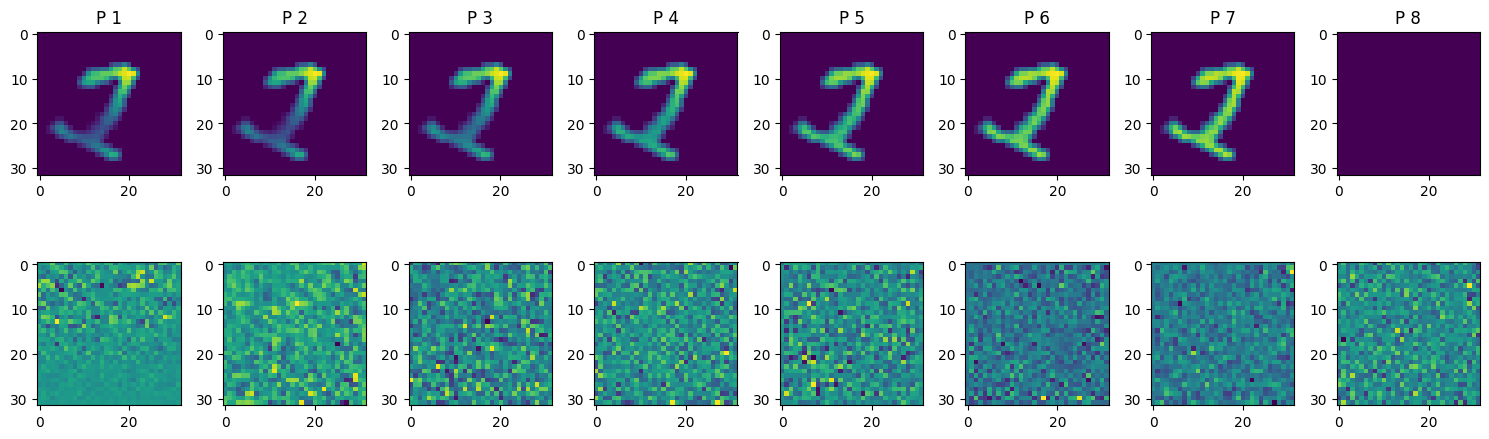

plane 1 | SSIM = 0.0265 | PSNR = -29.1465 dB
plane 2 | SSIM = 0.0290 | PSNR = 17.2594 dB
plane 3 | SSIM = 0.0110 | PSNR = 15.7875 dB
plane 4 | SSIM = 0.0359 | PSNR = 16.6471 dB
plane 5 | SSIM = 0.0196 | PSNR = 16.4234 dB
plane 6 | SSIM = 0.0497 | PSNR = 17.8689 dB
plane 7 | SSIM = 0.0420 | PSNR = 18.9225 dB
plane 8 | SSIM = 0.0293 | PSNR = 17.3171 dB


In [3]:
import libs.reconstruction_lib.twist_utils as utils
x_recons = torch.linalg.pinv(LM.A)@torch.tensor(y_noisy).to(LM.device).float()
ssim_values, psnr_values = utils.comparison2(X, x_recons.cpu().numpy().reshape(32*32*8,1), nx, ny, nz, figsize=(15, 5), planes_to_plot=range(nz))

Run twist


Initial objective = 210293.58847882712, nonzeros = 0
Incrementing S = 2
Incrementing S = 4
Incrementing S = 8
Incrementing S = 16
Incrementing S = 32
Incrementing S = 64
Incrementing S = 128
Incrementing S = 256
Incrementing S = 512
Incrementing S = 1024
Incrementing S = 2048
Incrementing S = 4096
Incrementing S = 8192
Iteration = 2, objective = 39224.1345407131, nz = 8192, criterion = 813.4791705993343
Iteration = 3, objective = 18079.973096942616, nz = 8192, criterion = 539.0599866983345
Iteration = 4, objective = 13728.937794251344, nz = 8192, criterion = 240.65496554455865
Iteration = 5, objective = 6479.890658918791, nz = 8192, criterion = 528.0122354671834
Iteration = 6, objective = 4461.229764118557, nz = 8192, criterion = 311.5269996140737
Iteration = 7, objective = 3715.6383317249556, nz = 8192, criterion = 167.1268846967612
Iteration = 8, objective = 3134.065425797561, nz = 8192, criterion = 156.52032141066965
Iteration = 9, objective = 2730.285244692469, nz = 8192, criterio

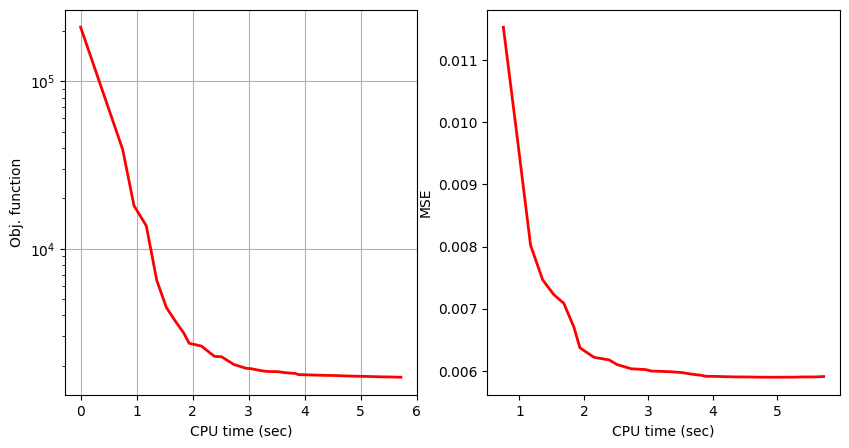

TwIST CPU time: 5.71875
MSE Loss: 5.9077e-03


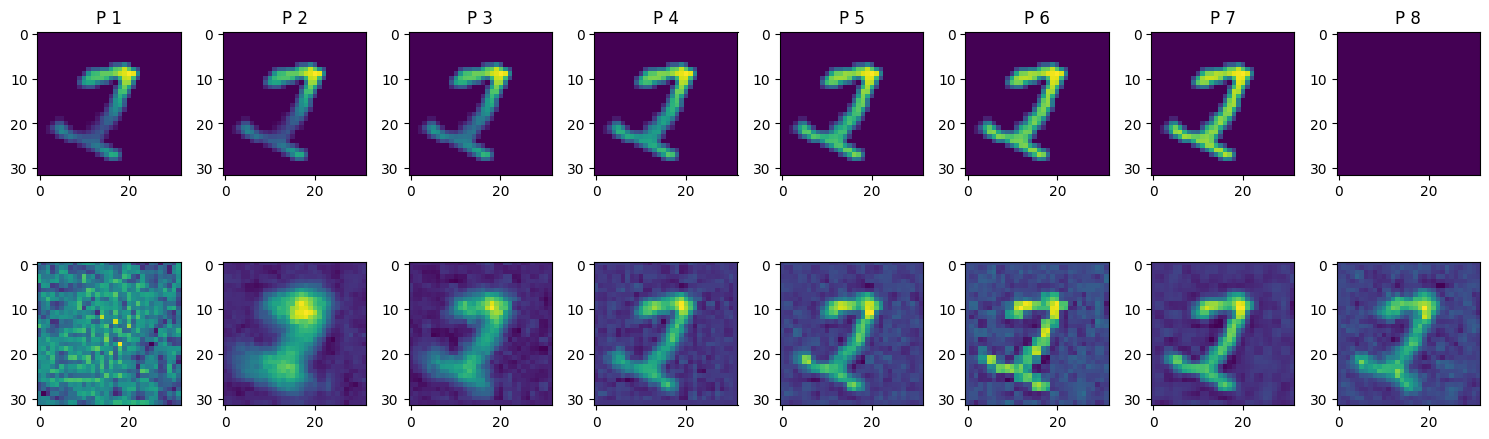

plane 1 | SSIM = 0.0068 | PSNR = -12.7491 dB
plane 2 | SSIM = 0.3429 | PSNR = 15.2512 dB
plane 3 | SSIM = 0.5205 | PSNR = 17.3652 dB
plane 4 | SSIM = 0.6431 | PSNR = 23.7744 dB
plane 5 | SSIM = 0.3244 | PSNR = 9.8795 dB
plane 6 | SSIM = 0.3860 | PSNR = 15.1257 dB
plane 7 | SSIM = 0.6860 | PSNR = 23.8432 dB
plane 8 | SSIM = 0.0603 | PSNR = 15.6392 dB


In [5]:
import libs.reconstruction_lib.TWIST as TWIST
import libs.reconstruction_lib.twist_utils as utils

y = y_noisy

# absAty = np.abs(utils.AT(y, FM, nx, ny, nz))
# tau = 1e-7*np.max(absAty) # Regularization parameter
tau = 1e-1 # Regularization parameter
Psi = 'SOFT_DWT' # denoising function ('TV', 'SOFT', 'SOFT_DWT')
Phi = 'L1_DWT' # regularization function ('TV', 'L1', 'L1_DWT')
lam1 = 1e-4 # twist parameter
stop_criterion = 1 # 0:non-zero components, 1:change in obj func, 2:estimate, 3:value of obj func 
tolA = 1e-3 # Stopping threshold
init = 0 # 0:zero, 1:random, 2:Aty, 3:init_x given by user
init_x = None # initial estimate

x_twist, dummy, obj_twist, times_twist, dummy, mse_twist, dummy = TWIST.TwIST(y, FM, tau, nx, ny, nz,
                                                                                Psi=Psi, Phi=Phi,
                                                                                lam1=1e-4, alpha=0, beta=0,
                                                                                stop_criterion=stop_criterion, tolA=tolA,
                                                                                init=init, init_x=init_x,
                                                                                enforceMonotone=1,
                                                                                true_x=X, compute_mse=1,
                                                                                verbose=1)

utils.plot_obj_mse(obj_twist, times_twist, mse_twist, figsize=(10,5))

ssim_values, psnr_values = utils.comparison2(X, x_twist, nx, ny, nz, figsize=(15, 5), planes_to_plot=range(nz))


Initial objective = 134061.8089485917, nonzeros = 0
Incrementing S = 2
Incrementing S = 4
Incrementing S = 8
Incrementing S = 16
Incrementing S = 32
Incrementing S = 64
Incrementing S = 128
Incrementing S = 256
Incrementing S = 512
Incrementing S = 1024
Incrementing S = 2048
Incrementing S = 4096
Incrementing S = 8192
Iteration = 2, objective = 31629.072922526622, nz = 8192, criterion = 764.0709671860736
Iteration = 3, objective = 19678.117408866525, nz = 8192, criterion = 377.84716431408515
Iteration = 4, objective = 17299.237764124882, nz = 8192, criterion = 120.88959504173768
Iteration = 5, objective = 12898.916393620062, nz = 8192, criterion = 254.3650437379499
Iteration = 6, objective = 11581.46354022913, nz = 8192, criterion = 102.13670770380047
Iteration = 7, objective = 11000.103972814793, nz = 8192, criterion = 50.19741808925424
Iteration = 8, objective = 9474.959148789725, nz = 8192, criterion = 138.64821894358897
Iteration = 9, objective = 8847.953619367587, nz = 8192, crit

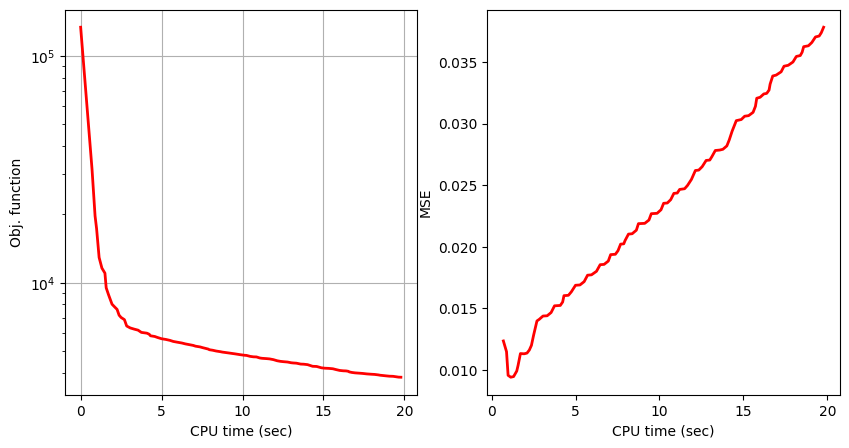

TwIST CPU time: 19.78125
MSE Loss: 3.7834e-02


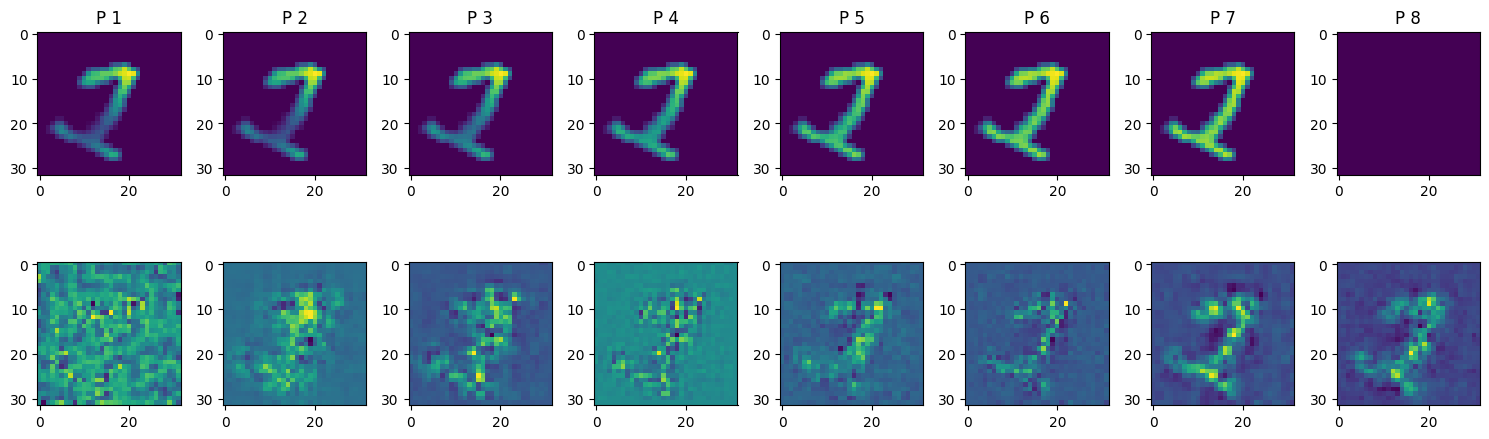

plane 1 | SSIM = 0.0123 | PSNR = -2.8927 dB
plane 2 | SSIM = 0.1648 | PSNR = 19.1938 dB
plane 3 | SSIM = 0.2292 | PSNR = 18.8444 dB
plane 4 | SSIM = 0.1668 | PSNR = 20.1418 dB
plane 5 | SSIM = 0.2371 | PSNR = 16.2993 dB
plane 6 | SSIM = 0.3179 | PSNR = 20.7320 dB
plane 7 | SSIM = 0.4317 | PSNR = 19.5698 dB
plane 8 | SSIM = 0.1268 | PSNR = 17.6815 dB


In [7]:
import libs.reconstruction_lib.TWIST as TWIST
import libs.reconstruction_lib.twist_utils as utils

y = y_noisy

# absAty = np.abs(utils.AT(y, FM, nx, ny, nz))
# tau = 1e-7*np.max(absAty) # Regularization parameter
tau = 1e-1 # Regularization parameter
Psi = 'SOFT_DWT' # denoising function ('TV', 'SOFT', 'SOFT_DWT')
Phi = 'L1_DWT' # regularization function ('TV', 'L1', 'L1_DWT')
lam1 = 1e-4 # twist parameter
stop_criterion = 1 # 0:non-zero components, 1:change in obj func, 2:estimate, 3:value of obj func 
tolA = 1e-3 # Stopping threshold
init = 0 # 0:zero, 1:random, 2:Aty, 3:init_x given by user
init_x = None # initial estimate

x_twist, dummy, obj_twist, times_twist, dummy, mse_twist, dummy = TWIST.TwIST(y, FM, tau, nx, ny, nz,
                                                                                Psi=Psi, Phi=Phi,
                                                                                lam1=1e-4, alpha=0, beta=0,
                                                                                stop_criterion=stop_criterion, tolA=tolA,
                                                                                init=init, init_x=init_x,
                                                                                enforceMonotone=1,
                                                                                true_x=X, compute_mse=1,
                                                                                verbose=1)

utils.plot_obj_mse(obj_twist, times_twist, mse_twist, figsize=(10,5))

ssim_values, psnr_values = utils.comparison2(X, x_twist, nx, ny, nz, figsize=(15, 5), planes_to_plot=range(nz))